In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from miniscope_utils_tf import *
#import utils as krist
import scipy.misc as sc
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import scipy.ndimage as ndim
import scipy.misc as misc
from scipy import signal
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
from os import listdir
from os.path import isfile, join
import os
import time
from itertools import permutations
from itertools import combinations
#import copy
#from bridson import poisson_disc_samples


In [2]:
#device = '/gpu:0'
#print(tf.test.is_gpu_available())
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
#model and loss
class Model(tf.keras.Model):
    def __init__(self, ):
        super(Model, self).__init__()
        
        self.samples = (768,768)   #Grid for PSF simulation

        # min and max lenslet focal lengths in mm
        self.fmin = 6.
        self.fmax = 20.
        self.ior = 1.56
        self.lam=510e-6
        # Min and max lenslet radii
        self.Rmin = self.fmin*(self.ior-1.)
        self.Rmax = self.fmax*(self.ior-1.)

        # Convert to curvatures
        self.cmin = 1/self.Rmax
        self.cmax = 1/self.Rmin
        self.xgrng = np.array((-1.8, 1.8)).astype('float32')    #Range, in mm, of grid of the whole plane (not just grin)
        self.ygrng = np.array((-1.8, 1.8)).astype('float32')

        self.t = 10.    #Distance to sensor from mask in mm

        #Compute depth range of virtual image that mask sees (this is assuming an objective is doing some magnification)

        self.zmin_virtual = 1./(1./self.t - 1./self.fmin)
        self.zmax_virtual = 1./(1./self.t - 1./self.fmax)
        self.CA = .9; #semi clear aperature of GRIN
        self.mean_lenslet_CA = .2 #average lenslest semi clear aperture in mm. 
            
        #Getting number of lenslets and z planes needed as well as defocus list
        self.ps = (self.xgrng[1] - self.xgrng[0])/self.samples[0]
        self.Nlenslets=np.int(np.floor((self.CA**2)/(self.mean_lenslet_CA**2)))
        self.Nz = np.ceil(np.sqrt(self.Nlenslets*2)).astype('int') #number of Zplanes 
        self.defocus_list = 1./(np.linspace(1/self.zmin_virtual, 1./self.zmax_virtual, self.Nz)) #mm or dioptres
        self.lenslet_offset=tfe.Variable(tf.zeros(self.Nlenslets),name='offset', dtype = tf.float32)
        #initializing the x and y positions
        [xpos,ypos, rlist]=poissonsampling_circular(self)
        
        self.rlist = tfe.Variable(rlist,name='rlist', dtype = tf.float32)
        self.xpos = tfe.Variable(xpos, name='xpos', dtype = tf.float32)
        self.ypos = tfe.Variable(ypos, name='ypos', dtype = tf.float32)
        
        #parameters for making the lenslet surface
        self.yg = tf.constant(np.linspace(self.ygrng[0], self.ygrng[1], self.samples[0]),dtype=tf.float32)
        self.xg=tf.constant(np.linspace(self.xgrng[0], self.xgrng[1], self.samples[1]),dtype=tf.float32)
        self.px=tf.constant(self.xg[1] - self.xg[0],tf.float32)
        self.py=tf.constant(self.yg[1] - self.yg[0],tf.float32)
        self.xgm, self.ygm = tf.meshgrid(self.xg,self.yg)

        #PSF generation parameters
        self.lam=tf.constant(510.*10.**(-6.),dtype=tf.float32)
        self.k = np.pi*2./self.lam
        
        fx = tf.constant(np.linspace(-1./(2.*self.ps),1./(2.*self.ps),self.samples[1]),dtype=tf.float32)
        fy = tf.constant(np.linspace(-1./(2.*self.ps),1./(2.*self.ps),self.samples[0]),dtype=tf.float32)
        self.Fx,self.Fy = tf.meshgrid(fx,fy)
        self.field_list = tf.constant(np.array((0., 0.)).astype('float32'))
        
        
    def call(self, inputs):
        T,aper=make_lenslet_tf(self) #offset added
        # Get psf stack
        zstack = []
        for defocus in self.defocus_list:
            zstack.append(gen_psf_ag_tf(T,self,defocus,'angle',0., prop_pad = 0.5))
        
        #Padding for fft
        psf_pad=[]
        Rmat = np.zeros((self.Nz,self.Nz))

        for z1 in range(self.Nz):
            psf_pad.append(pad_frac_tf(zstack[z1],1)) #how much to pad? 

        psf_spect=[]
        
        #Getting spectrum

        for z1 in range(self.Nz):
            psf_spect.append(tf.fft2d(tf.complex(psf_pad[z1],tf.constant(0.,dtype = tf.float32))))

        normsize=tf.to_float(tf.shape(psf_spect)[0]*tf.shape(psf_spect)[1])
        
        Rmat_tf=[]
        #calculating Xcorr

        for z1 in range(self.Nz):
            for z2 in range(self.Nz): 
                Fcorr = tf.conj(psf_spect[z1])*psf_spect[z2]
                Rmat_tf.append(tf.reduce_sum(tf.abs(Fcorr))/normsize)  #changed to one norm

        #Rmat=tf.reshape(Rmat_tf,(self.Nz,self.Nz))
            
        return Rmat_tf #note this returns int data type!! vector not matrix. This is also my loss!



In [4]:
def distances(model, x,y):
    dist = []
    dist_bool = []
    things = np.arange(model.Nlenslets)
    test_perm = list(permutations(things, 2))

    for i in range(0, len(test_perm)):
        dist_i = tf.sqrt(tf.square(x[test_perm[i][0]]-x[test_perm[i][1]])+tf.square(y[test_perm[i][0]]-y[test_perm[i][1]]))
        dist.append(dist_i)
        dist_bool.append(dist_i>0*model.mean_lenslet_CA)  ##fix later
        
    return dist, dist_bool, test_perm

        

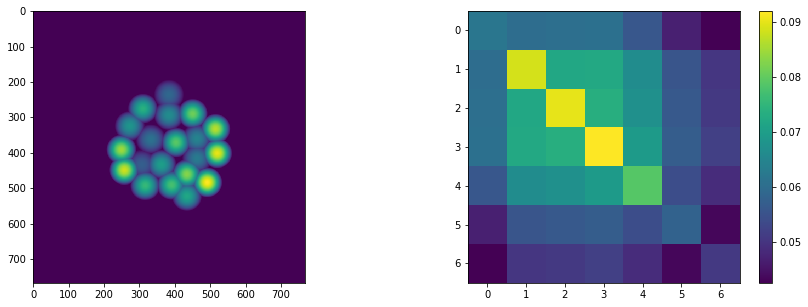

In [29]:
#start = time.time()
#with tf.device("/gpu:0"):
#    zstack=model(0)
#end = time.time()
#print(end - start)
#with tf.device("/cpu:0"):
model = Model()
Rmat=model(0)
R_init = Rmat
Tinit,_=make_lenslet_tf(model)
xinit = model.xpos
yinit = model.ypos
fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Tinit.numpy())
plt.subplot(1,2,2)
plt.imshow(tf.reshape(R_init,(7,7)))
plt.colorbar()

In [30]:
#have tf do everything for us
def loss (model):
    return tf.reduce_sum(tf.square(model(0)))

def gradient (model, myloss):
    with tf.GradientTape() as tape:
        lossvalue=myloss(model)
        return tape.gradient(lossvalue, model.variables),lossvalue
    

In [31]:
def constrain_distances(model, new_xpos, new_ypos, grads):
    test_dist, test_dist_bool, perm = distances(model, new_xpos, new_ypos)
    grads = np.ones((2,model.Nlenslets))
    for i in range(0,len(perm)):
        if test_dist_bool[i].numpy() == False:
            index = perm[i][0]
            grads[0,index] = 0
            grads[1,index] = 0
    return grads, test_dist, test_dist_bool

In [32]:
def remove_nan_gradients(grads):
   # Get rid of NaN gradients
   for g in range(0,len(grads)):
       if np.any(tf.is_nan(grads[g])):
           new_grad = tf.where(tf.is_nan(grads[g]), tf.zeros_like(grads[g]), grads[g])
           grads[g] = new_grad
   return grads

In [33]:
#new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 

In [19]:
grad,lossvalue=gradient(model,loss)

In [20]:
model.variables

[<tf.Variable 'offset:0' shape=(20,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32)>,
 <tf.Variable 'rlist:0' shape=(20,) dtype=float32, numpy=
 array([ 7.510588 ,  4.1187096,  3.4885247,  8.9915495,  4.3135133,
        11.2      ,  3.9407408,  4.5276594,  3.36     ,  9.975    ,
         5.32     ,  5.0267715,  3.7775147,  6.9391303,  6.0226417,
         8.184615 ,  4.764179 ,  5.6495576,  3.6272728,  6.448485 ],
       dtype=float32)>,
 <tf.Variable 'xpos:0' shape=(20,) dtype=float32, numpy=
 array([-0.02609794,  0.09538943, -0.15491165,  0.20361482,  0.62736076,
         0.15210196,  0.01704342, -0.3811284 , -0.0628114 , -0.6269362 ,
         0.5632275 , -0.49548104,  0.6345321 ,  0.34442714, -0.36731985,
         0.36442432, -0.14153299, -0.37281588,  0.36746144,  0.38986796],
       dtype=float32)>,
 <tf.Variable 'ypos:0' shape=(20,) dtype=float32, numpy=
 array([ 0.17591898,  0.48634943,  0.6803

In [21]:
grad

[<tf.Tensor: id=375409, shape=(20,), dtype=float32, numpy=
 array([ 7.728727  ,  0.9469888 ,  1.2757349 , -1.4145505 ,  3.2881818 ,
        -4.334525  ,  6.5640206 ,  4.819832  ,  3.8309026 , 13.251801  ,
         2.8576827 ,  8.439526  ,  5.454921  ,  1.1191217 , -0.4445294 ,
         0.94542927, -2.0090408 ,  2.1928787 ,  3.574812  ,  7.426081  ],
       dtype=float32)>,
 <tf.Tensor: id=375410, shape=(20,), dtype=float32, numpy=
 array([ 0.00293589,  0.00650525,  0.0138818 , -0.00045371,  0.00656986,
        -0.00011826, -0.01811361, -0.01061773,  0.01114798,  0.00269604,
        -0.00133753,  0.00799561,  0.00660801, -0.00031042,  0.00227591,
        -0.00073874,  0.00141644,  0.00014877,  0.02128816, -0.00182199],
       dtype=float32)>,
 <tf.Tensor: id=375411, shape=(20,), dtype=float32, numpy=
 array([-0.11025965, -0.02947607, -0.01118443,  0.04617653,  0.03204871,
        -0.01144558,  0.0463606 , -0.05442329,  0.00364932, -0.15820555,
         0.09598918, -0.10606514,  0.068029

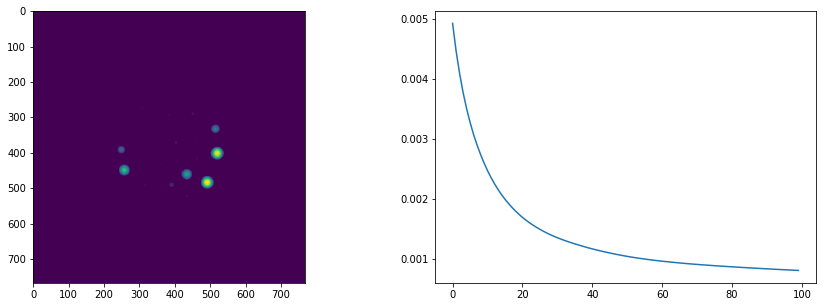

In [35]:
step_size = 0.0001
optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]
for i in range(100):
    grad,lossvalue=gradient(model,loss)

    new_xpos = model.xpos - step_size*grad[1]
    new_ypos = model.xpos - step_size*grad[2] 

    new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 

    grad[1] = grad[1]*new_grad[0,:]
    grad[2] = grad[2]*new_grad[1,:]    # update the gradient
    
    grads=remove_nan_gradients(grad)
    optimizer.apply_gradients(zip(grads,model.variables),global_step=tf.train.get_or_create_global_step())


    T,aper=make_lenslet_tf(model)

    losslist.append(lossvalue)
    plt.subplot(1,2,1)
    plt.cla()
    #plt.plot(model.xpos.numpy(),model.ypos.numpy(),'o')
    #plt.axis('equal')
    #rmean.append(tf.reduce_mean(model.rlist.numpy()))
    #plt.plot(rmean)
    plt.imshow(T.numpy())
    plt.subplot(1,2,2)
    plt.cla()
    plt.plot(losslist)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
grad

In [ ]:
jacobian=[]
for i in range (model.Nz**2):
    with tf.GradientTape() as tape:
        #tape.watch(model.variables)
        R=model(0)
        jacobian.append(tape.gradient(R[i], model.variables))


In [ ]:
tf.shape(jacobian)

In [ ]:
T,aper=make_lenslet_tf(model)
R=model(0)
fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(T.numpy())
plt.subplot(1,2,2)
plt.imshow(tf.reshape(R,(7,7)))
plt.colorbar()

In [36]:
zstack = []
for defocus in model.defocus_list:
    zstack.append(gen_psf_ag_tf(T,model,defocus,'angle',0., prop_pad = 0.5))

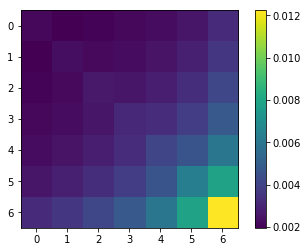

In [42]:
R =model(0)

plt.imshow(tf.reshape(R,(7,7)))
plt.colorbar()

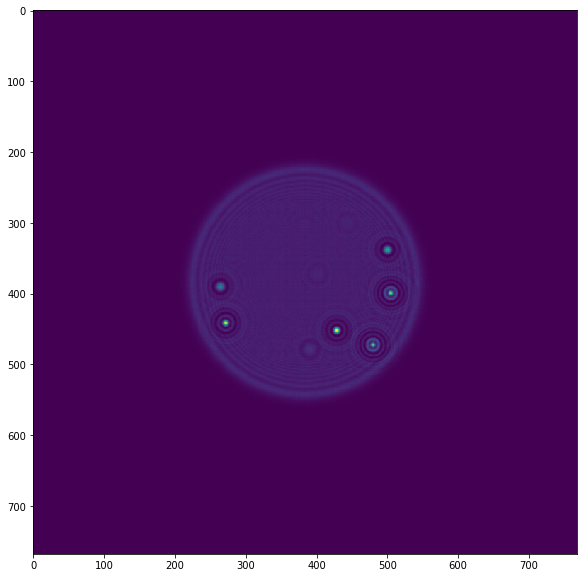

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(zstack[4])

In [ ]:
R=model(0)
plt.imshow(tf.reshape(R,(7,7)))
plt.colorbar()

In [ ]:
model2 = Model()
Rmat2=model2(0)
plt.imshow(tf.reshape(Rmat2,(7,7)))
plt.colorbar()

In [ ]:
with tf.device("/cpu:0"):
    with tf.GradientTape() as t:
        t.watch((model.xpos,model.ypos))
        Rmat=model(0) 
    for z in range(model.Nz**2)
    der = t.gradient(Rmat,(model.xpos,model.ypos))
#    dery = t.gradient(Rmat,model.ypos)

In [ ]:
tf.shape(der)

In [ ]:
der

In [ ]:
for i in range(5):
    with tf.device("/cpu:0"):
        model = Model()
        with tf.GradientTape() as t:
            t.watch(model.xpos)
            Rmat=model(0) 
        derx = t.gradient(Rmat,model.xpos)
        dery = t.gradient(Rmat,model.ypos)

    
    theta=theta+(J_f'*J_f)^(-1)*J_f'*residual;
    i
    sum(f)

In [ ]:
#Rmat = np.zeros((model.Nz,model.Nz))
start = time.time()
Rmat_tf=[]
psf_pad=[]

for z1 in range(model.Nz):
    psf_pad.append(pad_frac_tf(zstack[z1],1)) #how much to pad? 
    
psf_spect=[]

for z1 in range(model.Nz):
    psf_spect.append(tf.fft2d(tf.complex(psf_pad[z1],tf.constant(0.,dtype = tf.float32))))

normsize=tf.to_float(tf.shape(psf_spect)[0]*tf.shape(psf_spect)[1])

for z1 in range(model.Nz):
    for z2 in range( model.Nz): 
        Fcorr = tf.conj(psf_spect[z1])*psf_spect[z2]
        Rmat_tf.append(tf.reduce_sum(tf.abs(Fcorr)**2)/normsize)

Rmat=tf.reshape(Rmat_tf,(7,7))
end = time.time()
print(end - start)

In [ ]:
start = time.time()
Rmat = np.zeros((model.Nz,model.Nz))
#Rmat_tf=[]
psf_pad=[]

for z1 in range(model.Nz):
    psf_pad.append(pad_frac_tf(zstack[z1],1)) #how much to pad? 
    
psf_spect=[]

for z1 in range(model.Nz):
    psf_spect.append(tf.fft2d(tf.complex(psf_pad[z1],tf.constant(0.,dtype = tf.float32))))

normsize=tf.to_float(tf.shape(psf_spect)[0]*tf.shape(psf_spect)[1])

for z1 in range(model.Nz):
    for z2 in range( model.Nz): 
        Fcorr = tf.conj(psf_spect[z1])*psf_spect[z2]
        #Rmat_tf.append(tf.reduce_sum(tf.abs(Fcorr)**2)/normsize)
        Rmat[z1,z2] = tf.reduce_sum(tf.abs(Fcorr)**2)/normsize

Rmat = tf.transpose(Rmat)*(Rmat==0) + Rmat 

end = time.time()
print(end - start)

In [ ]:
freqs1 = np.fft.fftfreq(30*30, d=1./30).reshape(30, 30)
freqs2 = np.fft.fftfreq(30*30, d=1./40).reshape(30, 30)

freqp1=np.pad(freqs1, ((30,30),(30,30)), 'constant', constant_values=(0,0))
freqp2=np.pad(freqs2, ((30,30),(30,30)), 'constant', constant_values=(0,0))

#zstack1p= pad_frac_tf(freqs1,1) #how much to pad with?
#zstack2p= pad_frac_tf(freqs2,1)

psf_spect1 = tf.fft2d(tf.complex(freqp1,tf.constant(0.,dtype = tf.float64)))
psf_spect2 = tf.fft2d(tf.complex(freqp2,tf.constant(0.,dtype = tf.float64)))

Fcorr = tf.conj(psf_spect1)*psf_spect2
Rmat = tf.reduce_sum(tf.abs(Fcorr)**2)/(tf.to_float(tf.shape(freqp1)[0]*tf.shape(freqp1)[1]))
Rmat

In [ ]:
xcorr=signal.correlate2d(freqs1,freqs2)
xcorr_sum=np.sum(np.abs(xcorr)**2)
xcorr_sum

In [ ]:
Fcorrinv=np.fft.ifft2(Fcorr)
s=np.sum(np.abs(Fcorrinv)**2)
s

In [ ]:
psf_spect = np.fft.fft2(zstack[0],)
Rmat = np.zeros((model.Nz,model.Nz))
for z1 in range(Nz):
    for z2 in np.r_[z1:Nz]:
      
        Fcorr = np.conj(psf_spect[z1])*psf_spect[z2]
        Rmat[z1,z2] = np.sum(np.abs(Fcorr)**2)
        
Rmat = np.transpose(Rmat)*(Rmat==0) + Rmat
plt.imshow(Rmat,vmin=0)

In [ ]:
freqs = np.fft.fftfreq(9, d=1./9).reshape(3, 3)
np.fft.fft2(freqs)


In [ ]:
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_sum(tf.square(error))
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.Rlist])
